In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

from fastmri_recon.data.fastmri_sequences import ZeroFilled2DSequence, Masked2DSequence
from fastmri_recon.helpers.evaluate import METRIC_FUNCS, Metrics
from fastmri_recon.helpers.reconstruction import reco_and_gt_unet_from_val_file, reco_and_gt_net_from_val_file, reco_and_gt_zfilled_from_val_file
from fastmri_recon.models.cascading import cascade_net
from fastmri_recon.models.kiki import kiki_net
from fastmri_recon.models.pdnet import pdnet
from fastmri_recon.models.unet import unet

Using TensorFlow backend.


In [2]:
np.random.seed(0)

In [3]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In [4]:
AF = 4

In [5]:
val_path = '/media/Zaccharie/UHRes/singlecoil_val/'
val_gen_zero = ZeroFilled2DSequence(val_path, af=AF, norm=True, mode='validation')
# val_gen_zero.filenames = val_gen_zero.filenames[:2]
val_gen_scaled = Masked2DSequence(val_path, mode='validation', af=AF, scale_factor=1e6)
# val_gen_scaled.filenames = val_gen_scaled.filenames[:2]

In [6]:
all_net_params = [
    {
        'name': 'unet',
        'init_function': unet,
        'run_params': {
            'n_layers': 4,
            'pool': 'max',
            "layers_n_channels": [16, 32, 64, 128],
            'layers_n_non_lins': 2,
            'input_size': (320, 320, 1),
        },
        'val_gen': val_gen_zero,
        'run_id': 'unet_af4_1569210349',
        'reco_function': reco_and_gt_unet_from_val_file,
    },
    {
        'name': 'pdnet',
        'init_function': pdnet,
        'run_params': {
            'n_primal': 5,
            'n_dual': 5,
            'n_iter': 10,
            'n_filters': 32,
        },
        'val_gen': val_gen_scaled,
        'run_id': 'pdnet_af4_1568384763',
        'reco_function': reco_and_gt_net_from_val_file,
    },
    {
        'name': 'cascadenet',
        'init_function': cascade_net,
        'run_params': {
            'n_cascade': 5,
            'n_convs': 5,
            'n_filters': 48,
            'noiseless': True,
        },
        'val_gen': val_gen_scaled,
        'run_id': 'cascadenet_af4_1568926824',
        'reco_function': reco_and_gt_net_from_val_file,
    },
    {
        'name': 'kikinet',
        'init_function': kiki_net,
        'run_params': {
            'n_cascade': 2,
            'n_convs': 25,
            'n_filters': 32,
            'noiseless': True,
        },
        'val_gen': val_gen_scaled,
        'run_id': 'kikinet_af4_1568724379',
        'reco_function': reco_and_gt_net_from_val_file,
    },
]

In [7]:
def unpack_model(init_function=None, run_params=None, run_id=None, epoch=300, **dummy_kwargs):
    model = init_function(**run_params)
    chkpt_path = f'../checkpoints/{run_id}-{epoch}.hdf5'
    model.load_weights(chkpt_path)
    return model

def metrics_for_params(reco_function=None, val_gen=None, name=None, **net_params):
    model = unpack_model(**net_params)
    metrics = Metrics(METRIC_FUNCS)
    pred_and_gt = [
        reco_function(*val_gen[i], model)
        for i in tqdm_notebook(range(len(val_gen)), desc=f'Val files for {name}')
    ]    
    for im_recos, images in tqdm_notebook(pred_and_gt, desc=f'Stats for {name}'):
        metrics.push(images, im_recos)
    return metrics

def metrics_zfilled():
    metrics = Metrics(METRIC_FUNCS)
    pred_and_gt = [
        reco_and_gt_zfilled_from_val_file(*val_gen_scaled[i])
        for i in tqdm_notebook(range(len(val_gen_scaled)), desc='Val files for z-filled')
    ]    
    for im_recos, images in tqdm_notebook(pred_and_gt, desc='Stats for z-filled'):
        metrics.push(images, im_recos)
    return metrics

In [8]:
%%time
metrics = []
for net_params in all_net_params:
    metrics.append((net_params['name'], metrics_for_params(**net_params)))
    
metrics.append(('zfilled', metrics_zfilled()))

W0925 10:49:23.968963 140038341469952 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/keras/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



W0925 10:49:31.013389 140038341469952 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/keras/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



W0925 10:54:45.586067 140038341469952 deprecation.py:323] From /volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/fastmri_recon/helpers/nn_mri.py:84: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.



CPU times: user 53min 6s, sys: 7min 6s, total: 1h 12s
Wall time: 1h 32s


In [9]:
metrics

[('unet', PSNR = 31.78 +/- 6.534 SSIM = 0.7205 +/- 0.2595),
 ('pdnet', PSNR = 32.15 +/- 6.905 SSIM = 0.7292 +/- 0.2657),
 ('cascadenet', PSNR = 31.97 +/- 6.951 SSIM = 0.7191 +/- 0.2719),
 ('kikinet', PSNR = 28.43 +/- 4.345 SSIM = 0.6307 +/- 0.2366),
 ('zfilled', PSNR = 29.61 +/- 5.287 SSIM = 0.6577 +/- 0.2333)]

In [12]:
metrics.sort(key=lambda x: x[1].metrics['PSNR'].mean())

In [14]:
import pickle
with open('metrics_net_rec_fastmri', 'wb') as f:
    pickle.dump(metrics, f)

<IPython.core.display.Javascript object>


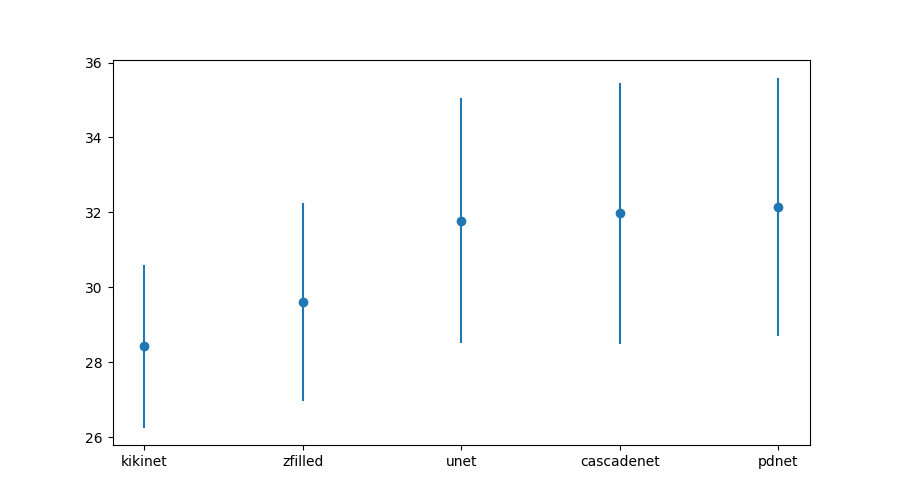

<ErrorbarContainer object of 3 artists>

In [13]:
plt.figure()
plt.errorbar(
    [name for name, _ in metrics], 
    [metric.metrics['PSNR'].mean() for _, metric in metrics], 
    [metric.metrics['PSNR'].stddev() for _, metric in metrics],
    linestyle='None', 
    marker='o',
)

<IPython.core.display.Javascript object>


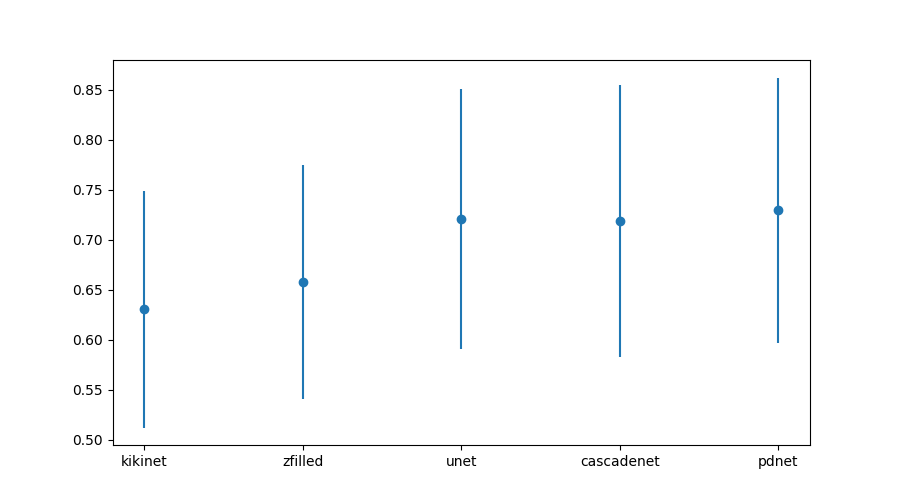

<ErrorbarContainer object of 3 artists>

In [15]:
plt.figure()
plt.errorbar(
    [name for name, _ in metrics], 
    [metric.metrics['SSIM'].mean() for _, metric in metrics], 
    [metric.metrics['SSIM'].stddev() for _, metric in metrics],
    linestyle='None', 
    marker='o',
)